In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.wcs import WCS

import tessreduce as tr

%matplotlib widget

In [11]:
def magnitude(flux, zp = 20.023960740994795):
    m = -2.5 * np.log10(flux) + zp
    return m

def magnitude_error(f, df, dzp):
    return np.sqrt((-2.5 / np.log(10) * df/ (f))**2 + dzp**2)

def flux_to_jansky(flux, zp = 20.44):
    c = (zp - 8.9) / -2.5
    return flux * 1e6 * 10**c

def jansky_error(mag, mag_error):
    return np.sqrt((-0.4 * np.log(10) * 10**((8.9 - mag)/2.5))**2 * mag_error**2) * 1e6

In [12]:
df = pd.read_csv('/Users/zgl12/Python_Scripts/SN2019VXM/TESS_Outlines/s18_4_1_control_curves.csv')

ras = df['RA'].values
decs = df['DEC'].values

In [13]:
cam = 4
ccd = 1
hdul = fits.open(f'/Users/zgl12/Python_Scripts/SynDiff/TESS_Images/s0017/tess2019284032926-s0017-{cam}-{ccd}-0161-s_ffic.fits')

data = hdul[1].data
header = hdul[1].header
wcs = WCS(header)

hdul.close()
xs, ys = wcs.all_world2pix(ras, decs, 0)

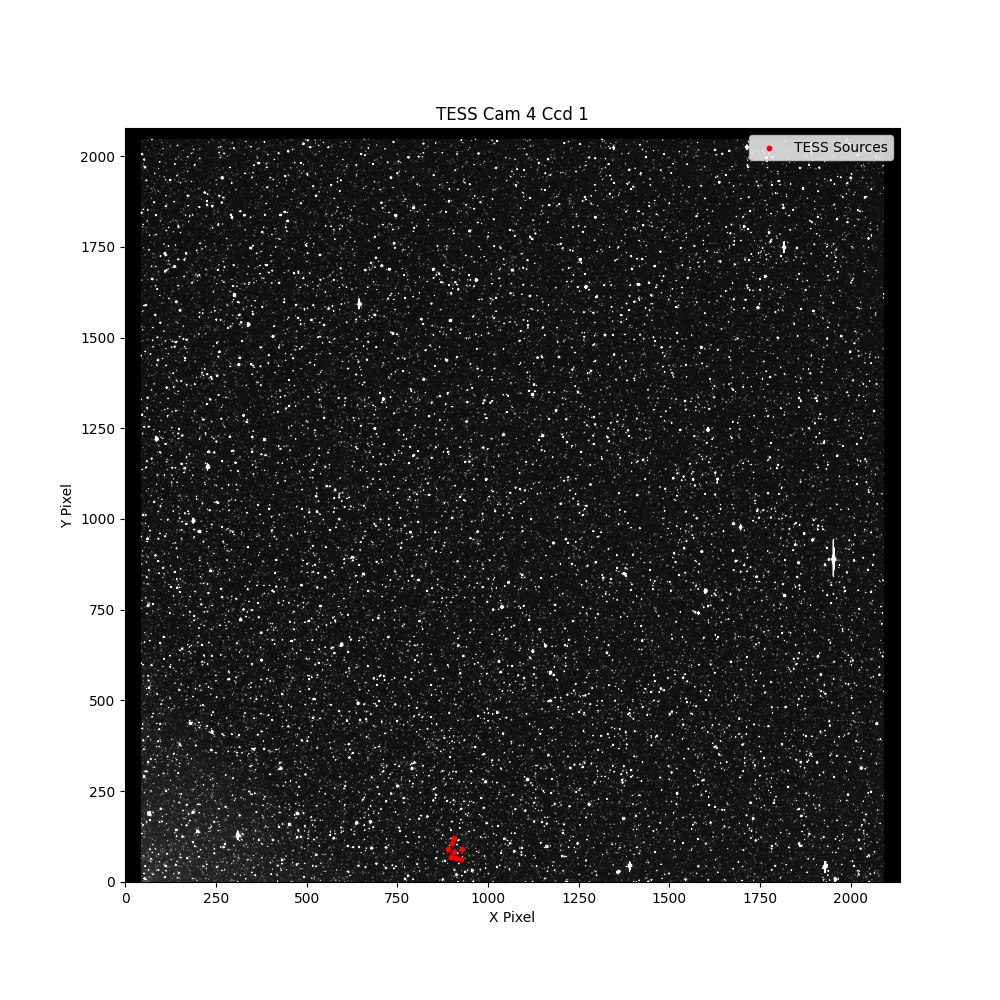

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='gray', origin='lower', vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 99))
plt.scatter(xs, ys, s=10, c='red', marker='o', label='TESS Sources')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title(f'TESS Cam {cam} Ccd {ccd}')
plt.legend()
plt.show()

In [20]:
sector = 17

obs = tr.spacetime_lookup(299.618917, 62.137731, time=58804, print_table=False)

obs


[[299.618917, 62.137731, 14, 2, 1, False],
 [299.618917, 62.137731, 15, 2, 1, False],
 [299.618917, 62.137731, 16, 2, 2, False],
 [299.618917, 62.137731, 17, 4, 1, False],
 [299.618917, 62.137731, 18, 4, 1, True],
 [299.618917, 62.137731, 21, 4, 4, False],
 [299.618917, 62.137731, 24, 3, 3, False],
 [299.618917, 62.137731, 41, 2, 1, False],
 [299.618917, 62.137731, 47, 4, 4, False],
 [299.618917, 62.137731, 48, 4, 4, False],
 [299.618917, 62.137731, 51, 4, 3, False],
 [299.618917, 62.137731, 54, 4, 2, False],
 [299.618917, 62.137731, 55, 4, 2, False],
 [299.618917, 62.137731, 56, 3, 3, False],
 [299.618917, 62.137731, 57, 3, 4, False],
 [299.618917, 62.137731, 58, 4, 1, False],
 [299.618917, 62.137731, 60, 4, 4, False],
 [299.618917, 62.137731, 74, 3, 4, False],
 [299.618917, 62.137731, 75, 3, 4, False],
 [299.618917, 62.137731, 76, 3, 4, False],
 [299.618917, 62.137731, 77, 3, 3, False],
 [299.618917, 62.137731, 78, 3, 3, False],
 [299.618917, 62.137731, 81, 4, 2, False],
 [299.618917

In [21]:
methods = 'aperture'

obs_df = pd.DataFrame(obs, columns=['RA', 'Dec', 'Sector', 'Camera', 'CCD',  'Covers'])

index = int(obs_df[obs_df['Sector'] == sector].index.values[0])

index

# # for i in tqdm(range(len(index)), desc='Sectors'):
# saving_df = pd.DataFrame(columns=['MJD', 'uJy', 'duJy', 'm', 'dm', 'd_ZP', 'ZP', ' Method', 'Sector'])

sector = obs_df.loc[index, 'Sector']

sector

17

In [22]:
tess = tr.tessreduce(obs_list=obs[index], plot=False, phot_method=methods, sourcehunt=False, calibrate = True, verbose = False, num_cores=3)

!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
field calibration


In [23]:
tess.lc.shape

(3, 1126)

In [24]:
saving_df = pd.DataFrame(columns=['MJD', 'uJy', 'duJy', 'm', 'dm', 'd_ZP', 'ZP', 'Method', 'Sector'])

mag = magnitude(tess.lc[1], zp = tess.zp)
mag_err = magnitude_error(tess.lc[1], tess.lc[2], tess.zp_e)

saving_df['MJD'] = tess.lc[0]
saving_df['uJy'] = flux_to_jansky(tess.lc[1], zp = tess.zp)
saving_df['duJy'] = jansky_error(mag, mag_err)
saving_df['m'] = mag
saving_df['dm'] = mag_err
saving_df['d_ZP'] = tess.zp_e
saving_df['ZP'] = tess.zp
saving_df['Method'] = methods
saving_df['Sector'] = sector

savepath = '/Users/zgl12/Python_Scripts/SN2019VXM/TESS_Control_Curves/'
    
saving_df.to_csv(f'{savepath}tess_sector_{sector}_{methods}_vxm.csv', index=False)